# 1. Imports & Config

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import ndarray
from matplotlib.pyplot import subplots, show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# model building imports
import keras
from keras import Model, Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping
from keras.utils import Sequence, load_img, img_to_array

import keras_tuner
# augmentation operations
from keras.layers import RandomBrightness, RandomFlip, RandomRotation
from keras.layers import Pipeline
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [2]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: []


In [3]:
print('num gpus:', len(tf.config.list_physical_devices('GPU')))

num gpus: 0


In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
# importing the dataset
metadata = pd.read_csv('../Data/rare_species/metadata.csv')
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
723,81ac1d9e-769f-4011-9e98-db1173e41911,14690054,460290,animalia,arthropoda,formicidae,arthropoda_formicidae/14690054_460290_eol-full...
10988,efe560b9-e687-4330-9bd1-d76c25c0f264,20143603,331381,animalia,chordata,plethodontidae,chordata_plethodontidae/20143603_331381_eol-fu...
8508,8fbce9dd-8068-4116-a451-2c52f63d86af,20894724,858738,animalia,arthropoda,tettigoniidae,arthropoda_tettigoniidae/20894724_858738_eol-f...
11347,9fd8f935-4ae3-4faa-8bd0-de04aec2968d,21307835,45509269,animalia,chordata,laridae,chordata_laridae/21307835_45509269_eol-full-si...
4432,eeb5fdc8-71a1-408b-94a1-0ae592724596,29689181,491832,animalia,arthropoda,formicidae,arthropoda_formicidae/29689181_491832_eol-full...


In [6]:
# applying the filepath
metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join('../Data/rare_species', x))

In [7]:
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
9291,c85ea77c-0e3a-4b5c-8955-d1b1da96427f,29902205,1065065,animalia,chordata,bucerotidae,../Data/rare_species\chordata_bucerotidae/2990...
4408,8f5bae4a-1568-4e0f-8aa4-41e62bc448fa,28914699,45514240,animalia,chordata,vangidae,../Data/rare_species\chordata_vangidae/2891469...
3989,28aeca09-7888-4ade-b468-384c1d8389a5,20991873,45276219,animalia,cnidaria,acroporidae,../Data/rare_species\cnidaria_acroporidae/2099...
10006,661795e2-e505-4a52-8997-d2361dbb8e21,28214384,1065290,animalia,arthropoda,apidae,../Data/rare_species\arthropoda_apidae/2821438...
10294,45146152-8913-438b-b147-beb59ba263fb,29638870,889096,animalia,arthropoda,formicidae,../Data/rare_species\arthropoda_formicidae/296...


# 2.  Preprocessing

In [8]:
metadata.phylum.unique()

array(['mollusca', 'chordata', 'arthropoda', 'echinodermata', 'cnidaria'],
      dtype=object)

In [9]:
print(metadata['family'].value_counts())

family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
                  ... 
cyprinodontidae     30
alligatoridae       30
balaenidae          30
goodeidae           30
siluridae           29
Name: count, Length: 202, dtype: int64


In [10]:
num_classes = metadata['family'].nunique()
num_classes

202

our dataset is inbalaced and has a length of 202 classes

In [11]:
# Transforming our target and feature into a int
label_encoder = LabelEncoder()
metadata['target'] = label_encoder.fit_transform(metadata['family'])


In [12]:
metadata['target'].sample(10)

8473     25
1930    126
9493     25
3615     33
8586     10
175      15
210      58
7782     15
7357     62
3344     57
Name: target, dtype: int64

### Spliting the data

In [13]:
# SSpliting the data while keeping the same distribuition of classes(target) - 70%/20%/10%

train, temp = train_test_split(metadata, test_size=0.3,stratify=metadata['target'],random_state=1)

val, test = train_test_split(temp,test_size=1/3,stratify=temp['target'],random_state=1)

In [14]:
train.shape , val.shape , test.shape

((8388, 8), (2396, 8), (1199, 8))

Loading the images

In [15]:
# def load_image(df, path='file_path', label='target', image_size=(256, 256)):
#     X = []
#     y = []

#     for _, row in df.iterrows():
#         image = keras.utils.load_img(row[path], target_size=image_size)
#         input_arr = keras.utils.img_to_array(image) / 255.0  # Normalize
#         X.append(input_arr)
#         y.append(row[label])
    
#     return np.array(X), np.array(y)

In [ ]:
# X_train , y_train = load_image(train)
# X_val , y_val = load_image(val)
# X_test , y_test = load_image(test)

In [ ]:
# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [18]:
# # one-hot encoding the target
# y_train = to_categorical(y_train, num_classes=num_classes)
# y_val = to_categorical(y_val, num_classes=num_classes)
# y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [20]:
class ImageGenerator(Sequence):
    def __init__(self, df, image_size=(256, 256), batch_size=32, path_col='file_path', label_col='target', num_classes=202, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.batch_size = batch_size
        self.path_col = path_col
        self.label_col = label_col
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        return self.__data_generation(batch_df)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_df):
        X = []
        y = []
        for _, row in batch_df.iterrows():
            img = load_img(row[self.path_col], target_size=self.image_size)
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(to_categorical(row[self.label_col], num_classes=self.num_classes))
        return np.array(X), np.array(y)


In [21]:
train_df = ImageGenerator(train, batch_size=32, image_size=(256, 256), num_classes=num_classes)
val_df = ImageGenerator(val, batch_size=32, image_size=(256, 256), num_classes=num_classes, shuffle=False)
test_df = ImageGenerator(test, batch_size=32, image_size=(256, 256), num_classes=num_classes, shuffle=False)


# 3. Models

In [22]:
augmentation_layer = Sequential(
    [
        RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),
        RandomFlip(),
        RandomRotation(factor=0.2, fill_mode="reflect")
    ], 
    name="augmentation_layer")


In [23]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

In [24]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)

In [25]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [26]:
input_shape = (256,256,3)

epochs = 200
batch_size = 32

## Model 1

In [27]:
def build_transfg_like(input_shape=input_shape, num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        
        augmentation_layer,
        
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        
        Dense(256, activation="relu"),
        Dropout(0.5),
        
        Dense(num_classes, activation="softmax")
    ], 
        name="TransFG_CNN")
    
    model.summary()
    
    return model

In [28]:
model_1 = build_transfg_like()

model_1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "TransFG_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 202)            │        51,914 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,699,850 (128.55 MB)

 Trainable params: 33,699,850 (128.55 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# train the model
_1 = model_1.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


238/263 ━━━━━━━━━━━━━━━━━━━━ 18s 734ms/step - accuracy: 0.0138 - loss: 5.2639

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 232s 881ms/step - accuracy: 0.0142 - loss: 5.2608 - val_accuracy: 0.0359 - val_loss: 5.1251 - learning_rate: 0.0100
Epoch 2/200
 81/263 ━━━━━━━━━━━━━━━━━━━━ 2:08 708ms/step - accuracy: 0.0303 - loss: 5.1633

KeyboardInterrupt: 

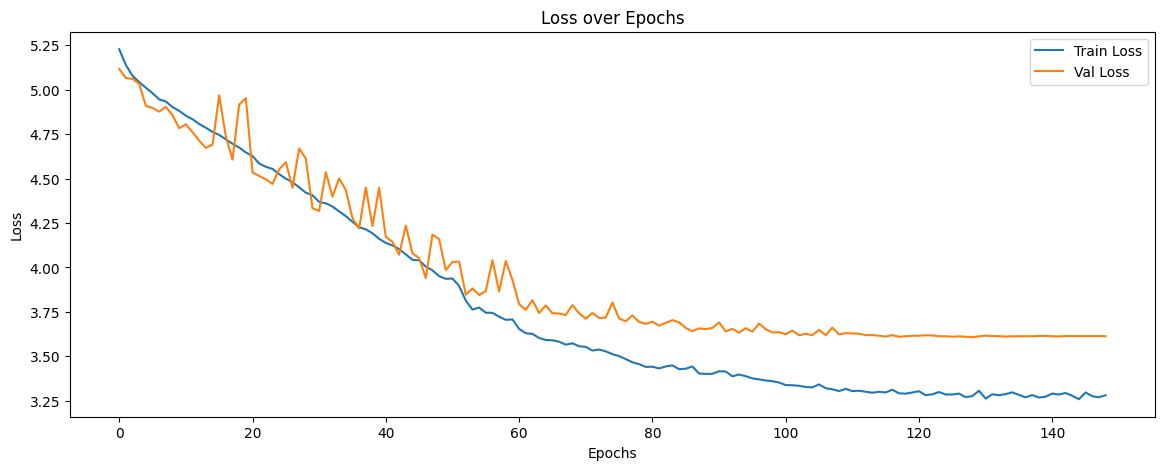

In [28]:
plt.figure(figsize=(14, 5))

plt.plot(_1.history['loss'], label='Train Loss')
plt.plot(_1.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


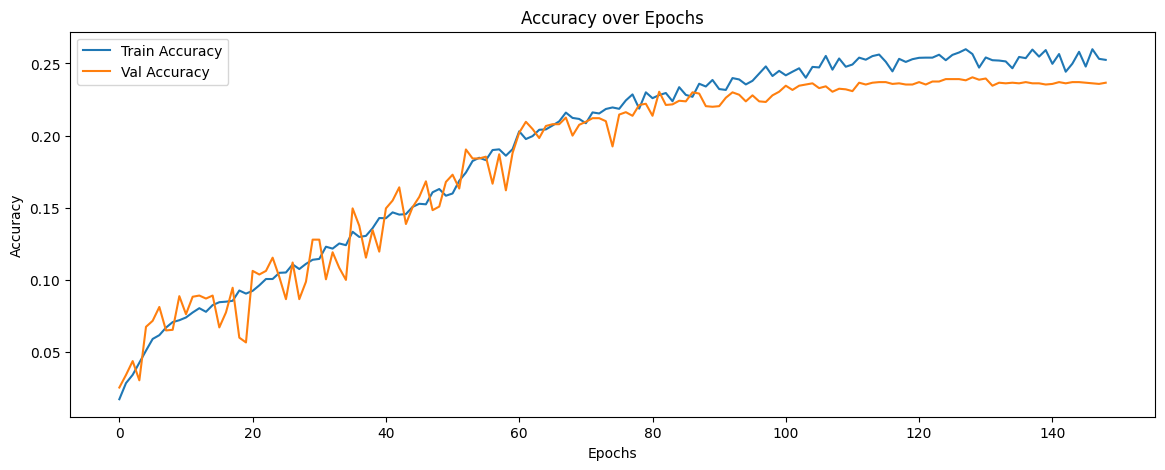

In [29]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_1.history['accuracy'], label='Train Accuracy')
plt.plot(_1.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

## Model 2

In [30]:
def build_ffvt(input_shape=input_shape, num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,
        
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), padding="same", activation="relu"),  # extra layer to simulate fusion
        MaxPooling2D((2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        
        Dense(num_classes, activation="softmax"),
    ], 
        name="FFVT_Sequential")
    
    model.summary()
    
    return model

In [31]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [32]:
model_2 = build_ffvt()

model_2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "FFVT_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,046,986 (129.88 MB)

 Trainable params: 34,046,986 (129.88 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
X_train.dtype

dtype('float32')

In [34]:
# train the model
_2 = model_2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks= [lr_reduction , early_stop]
)

Epoch 1/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 159s 604ms/step - accuracy: 0.0181 - loss: 5.1941 - val_accuracy: 0.0230 - val_loss: 5.0461 - learning_rate: 0.0100
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 156s 594ms/step - accuracy: 0.0282 - loss: 5.0349 - val_accuracy: 0.0497 - val_loss: 5.0135 - learning_rate: 0.0100
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 157s 595ms/step - accuracy: 0.0407 - loss: 5.0120 - val_accuracy: 0.0405 - val_loss: 4.9482 - learning_rate: 0.0100
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 156s 594ms/step - accuracy: 0.0472 - loss: 4.9359 - val_accuracy: 0.0271 - val_loss: 5.1799 - learning_rate: 0.0100
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 156s 595ms/step - accuracy: 0.0502 - loss: 4.9244 - val_accuracy: 0.0376 - val_loss: 5.0599 - learning_rate: 0.0100
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 157s 595ms/step - accuracy: 0.0701 - loss: 4.8577 - val_accuracy: 0.0655 - val_loss: 4.8733 - learning_rate: 0.0100
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 157s 595ms/step -

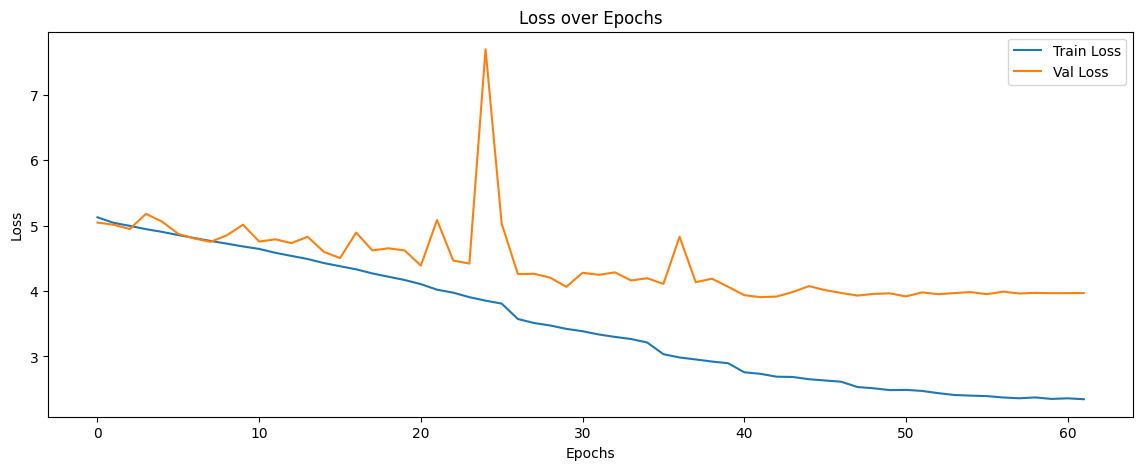

In [35]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_2.history['loss'], label='Train Loss')
plt.plot(_2.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

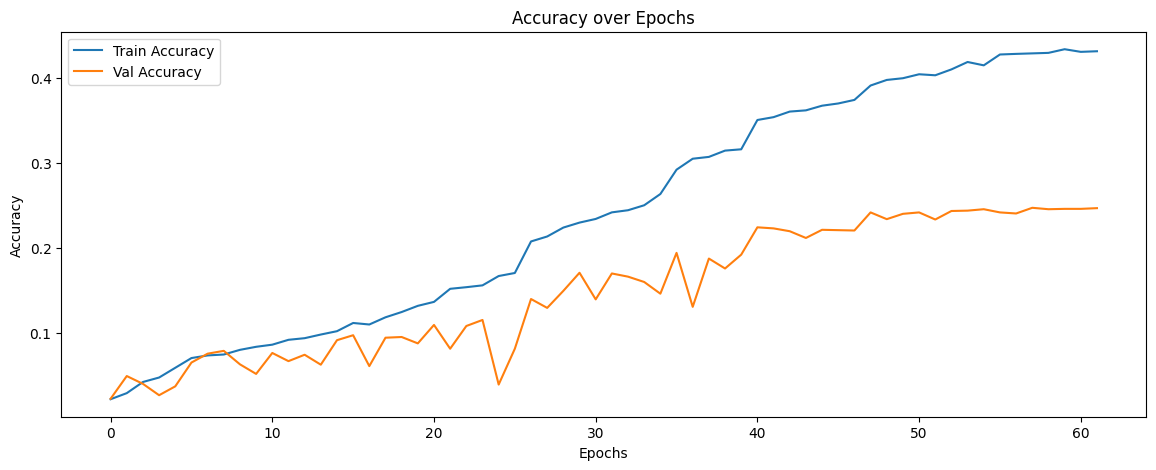

In [36]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_2.history['accuracy'], label='Train Accuracy')
plt.plot(_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model 3

In [37]:
def build_smvit(input_shape=input_shape, num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,
        Dropout(0.2),  
        
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        
        Dense(1024, activation="relu"),
        Dropout(0.5),
        
        
        Dense(num_classes, activation="softmax"),
    ],
        name="SMViT_Sequential")
    
    model.summary()
    
    return model

In [38]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [39]:
model_3 = build_smvit()

model_3.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "SMViT_Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 202)            │       207,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,934,986 (259.15 MB)

 Trainable params: 67,934,986 (259.15 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# train the model
_3 = model_3.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks= [lr_reduction , early_stop]
)

Epoch 1/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 157s 598ms/step - accuracy: 0.0133 - loss: 5.2350 - val_accuracy: 0.0346 - val_loss: 5.1901 - learning_rate: 0.0100
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 155s 589ms/step - accuracy: 0.0315 - loss: 5.0753 - val_accuracy: 0.0296 - val_loss: 5.1148 - learning_rate: 0.0100
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 155s 588ms/step - accuracy: 0.0338 - loss: 5.0119 - val_accuracy: 0.0434 - val_loss: 5.0937 - learning_rate: 0.0100
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 155s 588ms/step - accuracy: 0.0378 - loss: 4.9685 - val_accuracy: 0.0534 - val_loss: 5.0730 - learning_rate: 0.0100
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 155s 588ms/step - accuracy: 0.0473 - loss: 4.9640 - val_accuracy: 0.0655 - val_loss: 5.0357 - learning_rate: 0.0100
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 156s 592ms/step - accuracy: 0.0606 - loss: 4.9156 - val_accuracy: 0.0718 - val_loss: 4.9865 - learning_rate: 0.0100
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 154s 587ms/step -

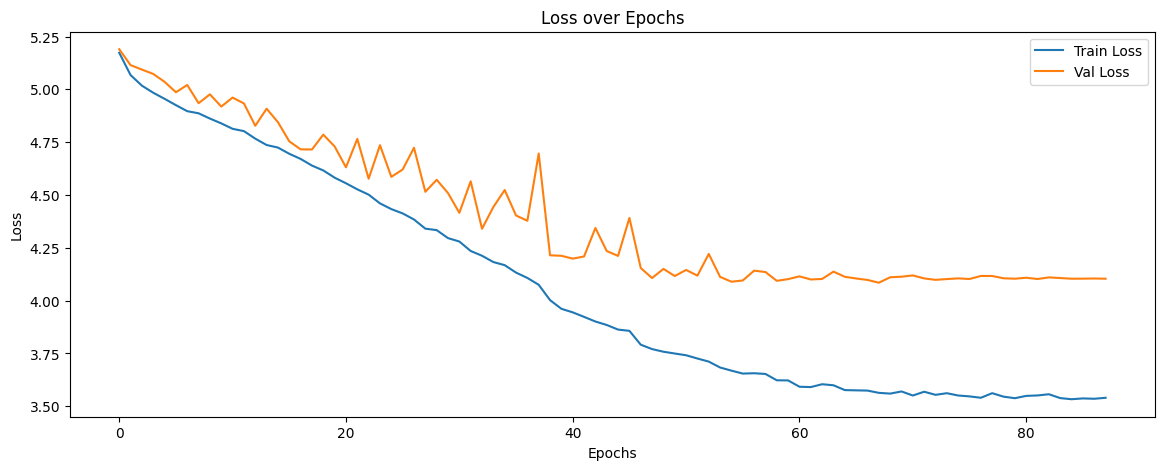

In [41]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_3.history['loss'], label='Train Loss')
plt.plot(_3.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

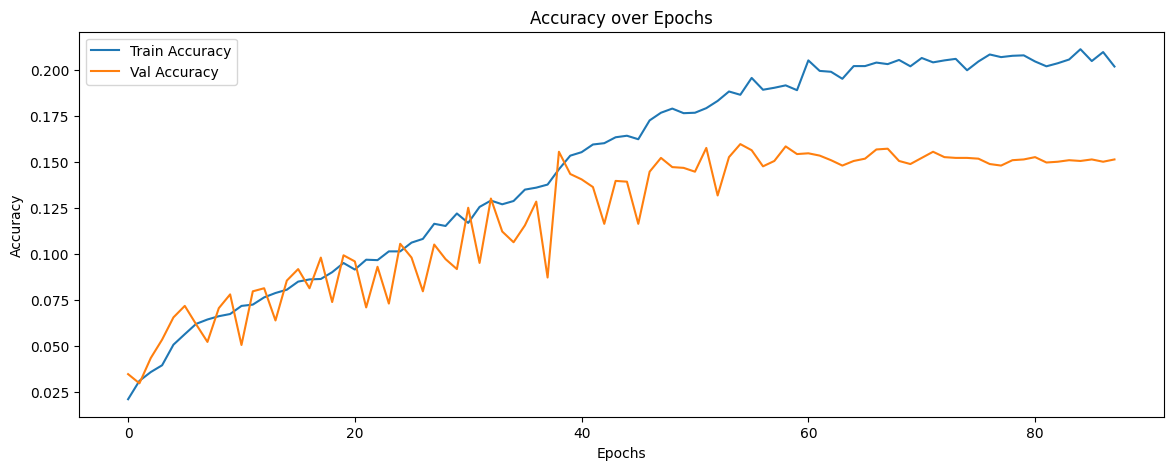

In [42]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_3.history['accuracy'], label='Train Accuracy')
plt.plot(_3.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Model 4

In [43]:
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D

def build_resnet50_with_head(input_shape=input_shape, num_classes=num_classes):

    inputs = Input(shape=input_shape, name="input_layer")
    x = augmentation_layer(inputs)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)


    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="ResNet50_CustomHead")
    
    model.summary()
    
    return model


In [44]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [45]:
model_4 = build_resnet50_with_head()

model_4.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "ResNet50_CustomHead"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_layer  │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ augmentation_lay… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c

 Total params: 24,164,170 (92.18 MB)

 Trainable params: 576,458 (2.20 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# # train the model
# _4 = model_4.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(X_val, y_val),
#     callbacks= [lr_reduction , early_stop]
# )

Epoch 1/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 825s 3s/step - accuracy: 0.0176 - loss: 5.2784 - val_accuracy: 0.0250 - val_loss: 5.1094 - learning_rate: 0.0100
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 809s 3s/step - accuracy: 0.0235 - loss: 5.1502 - val_accuracy: 0.0250 - val_loss: 5.1254 - learning_rate: 0.0100
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - accuracy: 0.0222 - loss: 5.1245 - val_accuracy: 0.0301 - val_loss: 5.0623 - learning_rate: 0.0100
Epoch 4/200
  9/263 ━━━━━━━━━━━━━━━━━━━━ 12:29 3s/step - accuracy: 0.0315 - loss: 5.1048

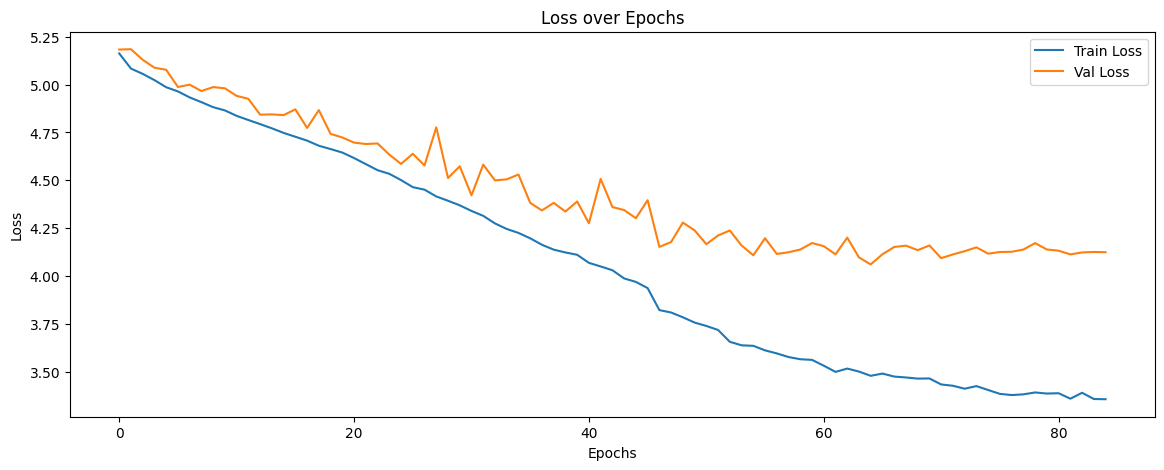

In [ ]:
plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_4.history['loss'], label='Train Loss')
plt.plot(_4.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

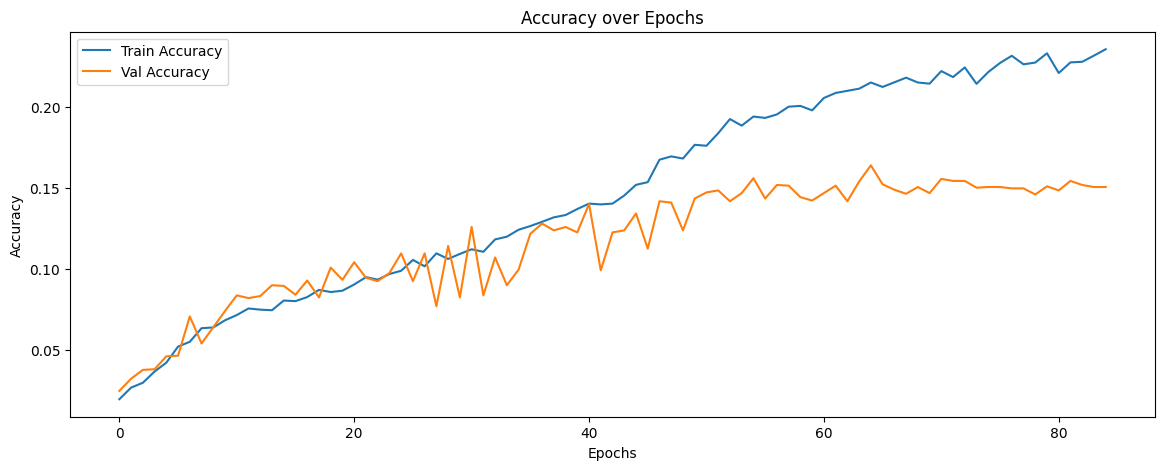

In [ ]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_4.history['accuracy'], label='Train Accuracy')
plt.plot(_4.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()